In [1]:
import os

import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import xarray as xr
import yaml

from src import data_catalog
from src.config import noaa_co2_flask_surface_dir, var_specs_fname
from src.utils_noaa_co2_flask_surface import co2_flask_surface_read_file
from src.esmlab_wrap import compute_ann_mean
from src.utils import time_year_plus_frac, print_timestamp
from src.utils_data_catalog import gen_ds_var
from src.utils_units import conv_units
%matplotlib inline

In [2]:
def dataset_summary(ds):
    time = time_year_plus_frac(ds, "time")
    print(f'samples = {len(time)}')
    year_min = np.floor(time.min())
    year_max = np.ceil(time.max())
    print(f'year_span = {year_min}-{year_max}' )
    print(f'samples per year = {len(time) / (year_max - year_min)}' )
    print('****************************************')

    ds["CO2"].plot()
    pf = P.polyfit(time, ds["CO2"].values, 3)
    print(pf)
    da_fit = ds["CO2"].copy(data=P.polyval(time, pf))
    da_fit.plot()
    plt.show()

    ds_ann = compute_ann_mean(ds)
    ds_ann["CO2"].plot()
    da_fit.plot()
    plt.show()

    ds_trunc = ds.isel(time=slice(12,-12))
    ds_mon_anom = ds_trunc - ds_ann.interp(time=ds_trunc.time)
    (ds_mon_anom["CO2"].interp(time=ds.time)).plot()
    plt.show()

    ds_mon_anom2 = ds.copy(deep=True)
    ds_mon_anom2["CO2"] = ds["CO2"] - da_fit
    ds_mon_anom2["CO2"].plot()
    plt.show()

    ds_year_max = ds_mon_anom.groupby("time.year").max("time", keep_attrs=True)
    ds_year_min = ds_mon_anom.groupby("time.year").min("time", keep_attrs=True)
    ds_seas_amp = ds_year_max - ds_year_min
    ds_seas_amp["CO2"].plot()

    ds_year_max = ds_mon_anom2.groupby("time.year").max("time", keep_attrs=True)
    ds_year_min = ds_mon_anom2.groupby("time.year").min("time", keep_attrs=True)
    ds_seas_amp = ds_year_max - ds_year_min
    ds_seas_amp["CO2"].isel(year=slice(1,-1)).plot()
    plt.show()

{'brw': {'year_span': (1972, 2015), 'lat': 71.32, 'lon': 203.4}, 'mlo': {'year_span': (1977, 2015), 'lat': 19.53, 'lon': 204.32}}
slice('1972-01-01', '2015-01-01', None)
samples = 516
year_span = 1972.0-2015.0
samples per year = 12.0
****************************************
[-4.62940814e+05  7.17924688e+02 -3.71338606e-01  6.41020584e-05]


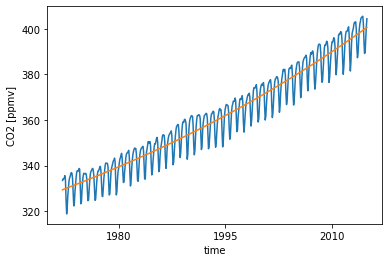

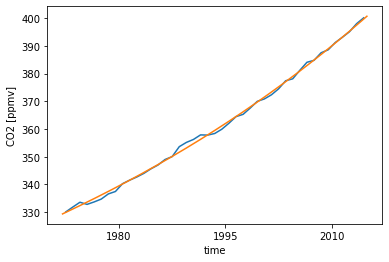

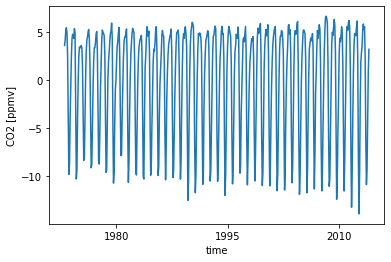

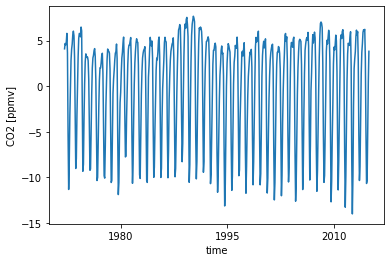

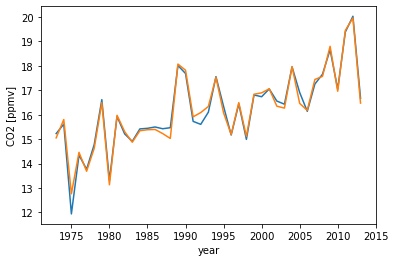

slice('1977-01-01', '2015-01-01', None)
samples = 456
year_span = 1977.0-2015.0
samples per year = 12.0
****************************************
[-2.05636240e+06  3.11295029e+03 -1.57128606e+00  2.64496890e-04]


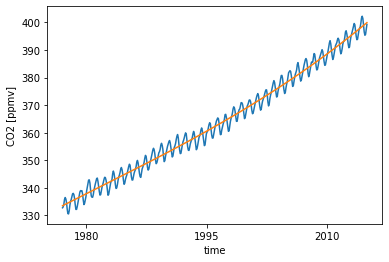

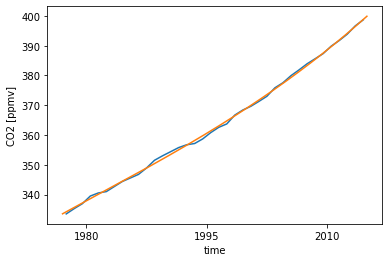

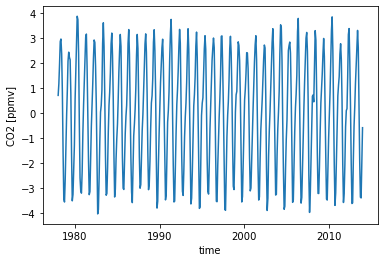

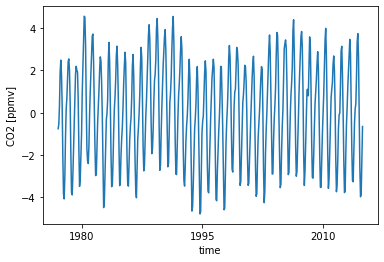

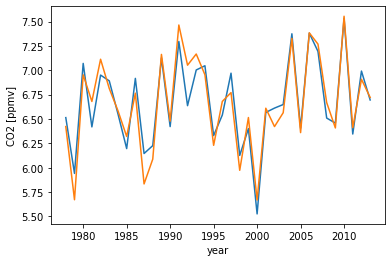

In [3]:
site_metadata_dict = {
    'brw': {"year_span": (1972, 2015), "lat": 71.32, "lon": (360-156.60)},
    'mlo': {"year_span": (1977, 2015), "lat": 19.53, "lon": (360-155.68)},
}
print(site_metadata_dict)

ds_obs = {}
for site, site_metadata in site_metadata_dict.items():
    path = os.path.join(noaa_co2_flask_surface_dir, "surface", f"co2_{site}_surface-flask_1_ccgg_month.txt")
    year_span = site_metadata["year_span"]
    time_sel = slice(f"{year_span[0]:04d}-01-01", f"{year_span[1]:04d}-01-01")
    print(time_sel)
    ds_obs[site] = co2_flask_surface_read_file(path)[["time_bounds", "CO2"]].sel(time=time_sel)
    for key in ["lat", "lon"]:
        ds_obs[site].attrs[key] = site_metadata[key]
    dataset_summary(ds_obs[site])

In [4]:
data_catalog.set_catalog("cesm_coupled")
ds_dict = {}
varname = "CO2"
component = "atm"
for expr in ["esm-hist", "esm-hist-cmip5"]:
    stream = "cam.h0" if "cmip5" not in expr else "cam2.h0"
    ds_dict[expr] = gen_ds_var(varname, component, expr, stream)

with open(var_specs_fname, mode="r") as fptr:
    var_specs_all = yaml.safe_load(fptr)
var_spec = var_specs_all[component]["vars"][varname]

active catalog: cesm_coupled
2020-03-02 15:52:49.289732(gen_ds_var):entering gen_ds_var, varname=CO2, experiment=esm-hist
2020-03-02 15:52:52.819627(gen_ds_var):entering gen_ds_var, varname=CO2, experiment=esm-hist-cmip5


2020-03-02 16:07:07.253647(<module>):loading model output for esm-hist at brw
2020-03-02 16:07:37.644341(<module>):loaded
samples = 516
year_span = 1972.0-2015.0
samples per year = 12.0
****************************************
[-5.39081475e+06  8.13947772e+03 -4.09694829e+00  6.87504751e-04]


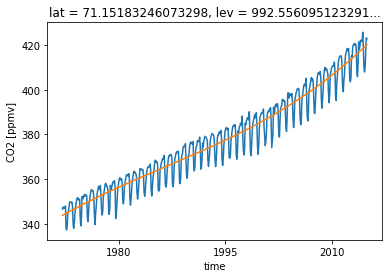

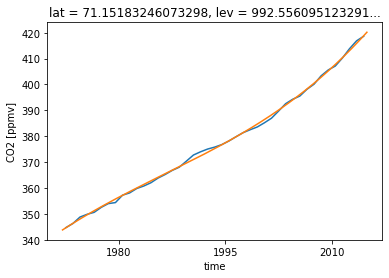

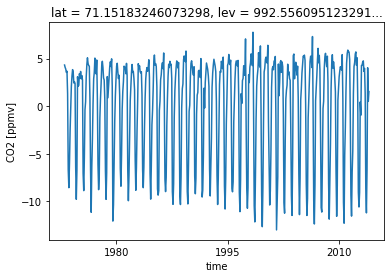

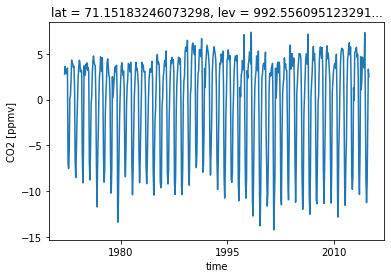

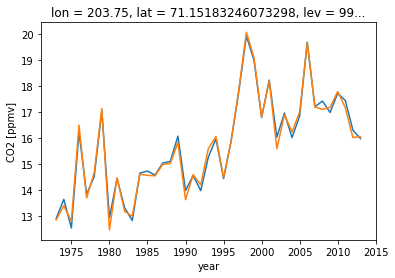

2020-03-02 16:07:39.045862(<module>):loading model output for esm-hist-cmip5 at brw
2020-03-02 16:08:08.587229(<module>):loaded
samples = 408
year_span = 1972.0-2006.0
samples per year = 12.0
****************************************
[ 1.58754122e+06 -2.37944176e+03  1.18804847e+00 -1.97557837e-04]


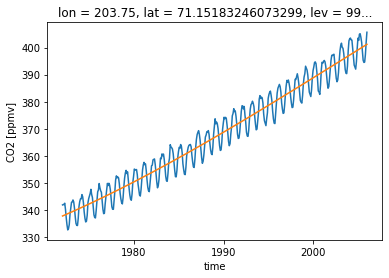

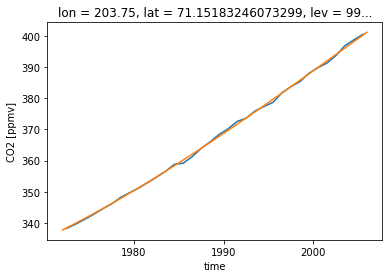

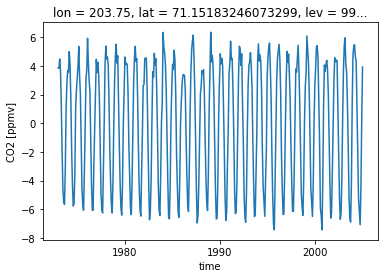

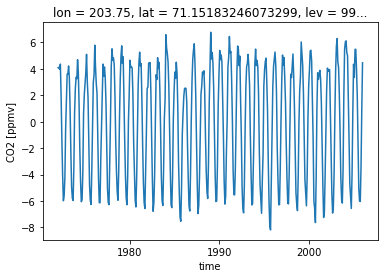

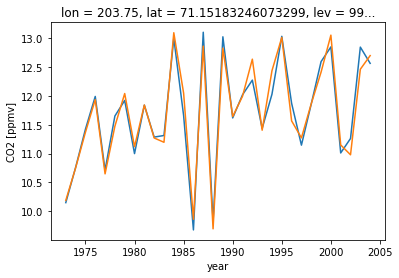

2020-03-02 16:08:09.871013(<module>):loading model output for esm-hist at mlo
2020-03-02 16:08:33.399216(<module>):loaded
samples = 456
year_span = 1977.0-2015.0
samples per year = 12.0
****************************************
[-6.36102900e+06  9.59391501e+03 -4.82371062e+00  8.08553144e-04]


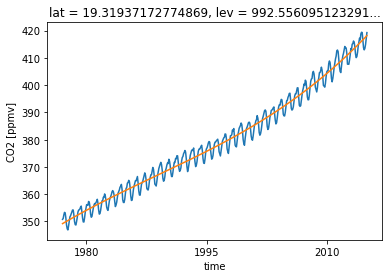

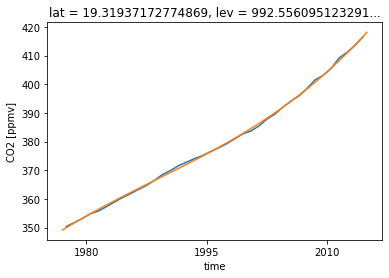

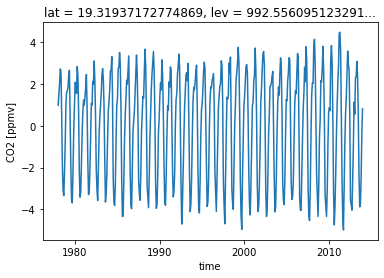

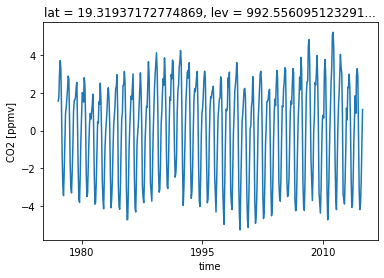

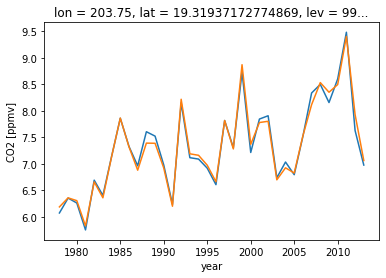

2020-03-02 16:08:36.001316(<module>):loading model output for esm-hist-cmip5 at mlo
2020-03-02 16:08:54.698605(<module>):loaded
samples = 348
year_span = 1977.0-2006.0
samples per year = 12.0
****************************************
[ 2.14976307e+06 -3.22319960e+03  1.61012850e+00 -2.67936283e-04]


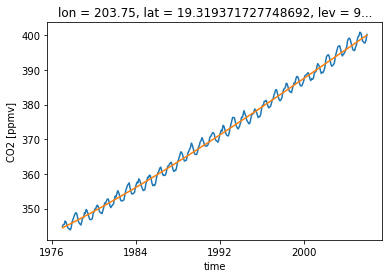

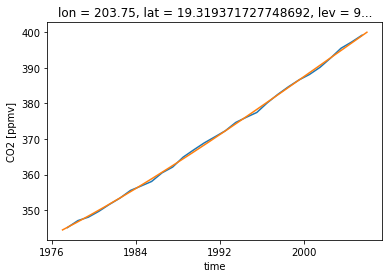

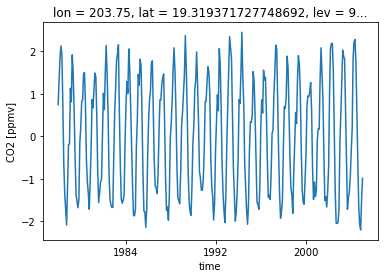

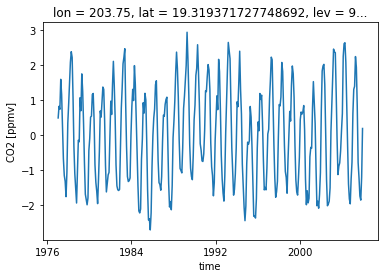

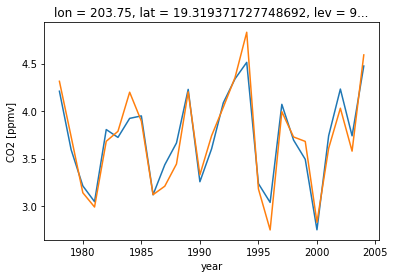

In [10]:
for site, site_metadata in site_metadata_dict.items():
    year_span = site_metadata["year_span"]
    time_sel = slice(f"{year_span[0]:04d}-01-01", f"{year_span[1]:04d}-01-01")
    seldict = {"lat": site_metadata["lat"], "lon": site_metadata["lon"]}
    iseldict = {"lev": -1}
    for expr, ds in ds_dict.items():
        ds_sel = ds[["time_bnds", "CO2"]].sel(seldict, method="nearest").isel(iseldict).sel(time=time_sel)
        if "ensemble" in ds_sel[varname].dims:
            ds_sel = ds_sel.isel(ensemble=0)
        print_timestamp(f"loading model output for {expr} at {site}")
        ds_sel.load()
        print_timestamp(f"loaded")
        if "unit_conv" in var_spec:
            ds_sel[varname].attrs["units"] = f"({var_spec['unit_conv']})({ds_sel[varname].attrs['units']})"
        if "display_units" in var_spec:
            ds_sel[varname] = conv_units(ds_sel[varname], var_spec["display_units"])
        dataset_summary(ds_sel)